In [1]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import copy
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cftime
# import xesmf as xe
import matplotlib.pyplot as plt

In [2]:
from lib import driver
# from lib import plot 
from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
from lib.tools import *

ERROR 1: PROJ: proj_create_from_database: Open of /home/ycheng/.conda/envs/cpc/share/proj failed


In [3]:
from lib import getCPCobs
from lib.getCPCobs import *

In [4]:
def check_lat_order(dataset,verbose=False):
    """
    Check the order of latitude coordinates in the dataset.
    
    Parameters:
    - dataset: xarray.Dataset or xarray.DataArray
    
    Returns:
    - True if latitude is ordered from North to South (N to S).
    - False if latitude is ordered from South to North (S to N).
    - None if the order is ambiguous or the dataset is empty.
    """
    if 'latitude' in dataset.coords:
        dataset = dataset.rename_dims({'latitude': 'lat', 'longitude': 'lon'})

    lat_coords = dataset['lat']
    lat_diff = lat_coords.diff(dim='lat')
    if verbose:
        print(lat_diff)

    if (lat_diff < 0.).all():
        dataset= dataset.sel(lat=dataset.lat[::-1])
        print('change latitude from S to N')
        # print(dataset.lat)
    elif (lat_diff > 0.).all():
        dataset = dataset
        print('====latitude from S to N----')
        # print(dataset.lat)
    else:
        print('!!!!!! Latitude ambiguous or unordered !!!!!!')
    return(dataset)



In [5]:
now = dt.now()
T_START = dt(2019,1,1) #dt(YEAR,MONTH,1)
# T_START = dt(2017,10,13) #dt(YEAR,MONTH,1)
T_END = dt(2019,12,31) #dt(YEAR,MONTH,LASTDAY)
endyear = np.min([now.year+1,int(T_END.year)+2])
years =  np.arange( int(T_START.year-1),endyear,1)# get one more year to avoid issue with running mean

ds1 = xr.open_mfdataset([f'data_retrospective/cpctmin.{year}.nc' for year in years])
ds2 = xr.open_mfdataset([f'data_retrospective/cpctmax.{year}.nc' for year in years])# cpc files are in degC
ds3 = ds1.merge(ds2,compat='override')
ds4 = ds3.assign(tavg=(("time", "lat", "lon"),np.nanmean([ds3.tmin,ds3.tmax],axis=0)))
obs = ds4.drop(('tmin','tmax'))


In [6]:
obs = obs+273.15 # make obs in K
obs.tavg.attrs['units']='K'

The follwing is just testing how to use ds.rolling

In [7]:

time = pd.date_range("2023-01-01", periods=10, freq="D")
data = np.arange(10)
da = xr.DataArray(data, dims=("time",), coords={"time": time})
da = xr.concat([da,da],dim='time')
rolling_mean_center = da.rolling(time=7, min_periods = 3, center=False).mean()
rolling_mean_center = rolling_mean_center.assign_coords({'dayofyear':('time',[(t.dayofyear-1)%365+1 for t in pd.DatetimeIndex(rolling_mean_center.time.data)])})
rolling_mean_center_group = rolling_mean_center.groupby("time.dayofyear").mean('time')
data = [1, 2, 8, 4, 5, 6, np.nan, np.nan, 9, 10]
da = xr.DataArray(data, dims=("time",))

# Apply a rolling mean with a window size of 3 and min_periods=2
rolling_mean = da.rolling(time=3, min_periods=3).mean()
rolling_mean2 = da.rolling(time=3, min_periods=3,center=True).mean()
print(rolling_mean)
print(rolling_mean2)


In [7]:
time_window = 7# 7 day running mean
clim = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1991to2020.nc')
clim = check_lat_order(clim)
dates = xr.cftime_range(start='0001-01-01', end='0001-12-31', freq='D')
clim = xr.DataArray(clim.climo, dims=['time','lat','lon'], 
                      coords={'time': dates, 'lat': clim.lat, 'lon': clim.lon})
clim = xr.Dataset(data_vars={'tavg': clim})
climappend = clim.isel(time=slice(-(time_window-1), None)) 
clim = xr.concat([climappend,clim],dim='time') # append data at the beginning for backward rolling mean
# climroll = clim.rolling({'time':time_window},min_periods=int(time_window)).mean()
climroll = clim.rolling({'time':time_window},min_periods=int(time_window),center=True).mean()

climroll = climroll.dropna(dim='time',how='all')
climatology = climroll.groupby("time.dayofyear").mean("time")

climatology.dayofyear
# print('------climatology------')
# print(climatology.tavg[0:8].sel(lat=slice(30,35),lon=slice(260,265)),climatology.tavg[0:5].sel(lat=slice(35,30),lon=slice(260,265)))

# climP = xr.open_dataset('/Projects/jalbers_process/CPC_data/temp.climo.grid2-areaAvg.1981to2010.nc')
# climP = check_lat_order(climP)
# climP = xr.DataArray(climP.climo, dims=['time','lat','lon'], 
#                       coords={'time': dates, 'lat': climP.lat, 'lon': climP.lon})
# climP = xr.Dataset(data_vars={'tavg': climP})


# climP = xr.concat([climP,climP],dim='time')
# # climProll = climP.drop_vars(['climatology_bounds']).rolling({'time':7},min_periods=int(7//2)).mean()
# climProll = climP.rolling({'time':7},min_periods=int(7//2)).mean()
# climatologyP = climProll.groupby("time.dayofyear").mean("time")

====latitude from S to N----


<xarray.DataArray 'dayofyear' (dayofyear: 365)>
array([  1,   2,   3, ..., 363, 364, 365])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [8]:
newlat, newlon = clim['lat'].data, clim['lon'].data
obs_interp = obs.interp(lat=newlat,lon=newlon)
obs = obs_interp

In [9]:
# obsroll = obs.rolling({'time':time_window},min_periods=int(time_window)).mean() # now read in extra year before the verification period
obsroll = obs.rolling({'time':time_window},min_periods=int(time_window),center=True).mean() # now read in extra year before the verification period
obsroll = obsroll.assign_coords({'dayofyear':('time',[(t.dayofyear-1)%365+1 for t in pd.DatetimeIndex(obsroll.time.data)])})
obsgroup = obsroll.groupby("dayofyear")
anom = obsgroup-climatology
tmp  = anom


In [29]:
# LIMdriver = driver.Driver(f'namelist_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map.py')
# LIMdriver.get_variables(read=True)
# varname = 'T2m'
# varobj = LIMdriver.use_vars[varname]['data']
# limlon = varobj.lon
# limlat = varobj.lat
# pthresh = 55


In [10]:
cpcmask = xr.open_dataset('data_clim/usa_mask.grid2_nan.nc')
# cpcmask = xr.open_dataset('data_clim/cpcmask.nc')
# cpcmask = xr.open_dataset('data_clim/cpcmask_T2m_grid.nc')
cpcmask = check_lat_order(cpcmask)


====latitude from S to N----


In [11]:
varname = 'T2m'
LIMpage_path = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map'
FCSTDIR = f'{LIMpage_path}/lim_t2m_retrospective/wk34separate_regression/' 
# FCSTDIR = f'{LIMpage_path}/lim_t2m_retrospective/wk34separate_regression/offset/' 
VERIFDIR = f'{FCSTDIR}'
anomvar = varname+'_anom'
spreadvar = varname+'_spread' 
T_INIT = dt(2019,12,31)
T_END  = dt(2019,12,31)

start_date = "2019-01-01"
end_date   = "2019-12-31"
# Create a date range with daily frequency for the year 2019
date_range = pd.date_range(start=start_date, end=end_date)
# files = [os.path.join(VERIFDIR, f'{varname}.{date}.nc') for date in date_range.strftime('%Y%m%d')]
# files = [os.path.join(VERIFDIR, f'{varname}_offset.{date}.nc') for date in date_range.strftime('%Y%m%d')]
# ds = xr.open_mfdataset(files)
ds = xr.open_dataset(f'{VERIFDIR}/{varname}.{T_INIT:%Y%m%d}.nc')
ds = check_lat_order(ds,verbose=True)

for label,lt in zip(['wk34'],[(21,28)]):
    # new dataset with current lead time. if more than one, concatenate lead times
    newds = xr.concat([ds.sel(lead_time=f'{i} days') for i in lt],dim='lead_time').mean('lead_time')
    anom   = newds[anomvar]
    spread = newds[spreadvar]



<xarray.DataArray 'lat' (lat: 90)>
array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.])
Coordinates:
  * lat      (lat) float64 88.0 86.0 84.0 82.0 80.0 ... -84.0 -86.0 -88.0 -90.0
change latitude from S to N


In [82]:
anom_obs = xr.concat([tmp.sel(time=T_INIT+timedelta(days=l)) for l in lt],dim='time').mean(dim='time')
anom_obs
# anom_obs_mask  = xr.where(~anom_obs.isnull() & ~anom.isnull(),anom_obs,np.nan)
# anom_mask = xr.where(~anom_obs.isnull() & ~anom.isnull(),anom,np.nan)
# spread_mask = xr.where(~anom_obs.isnull() & ~spread.isnull(),spread,np.nan)
# anom_obs_mask_us   = xr.where(cpcmask['mask'].isnull(),np.nan,anom_obs_mask['tavg']).rename('tavg')
# anom_mask_us       = xr.where(cpcmask['mask'].isnull(),np.nan,anom_mask['tavg']).rename('tavg')
# spread_mask_us     = xr.where(cpcmask['mask'].isnull(),np.nan,spread_mask['tavg']).rename('spread')


<xarray.Dataset>
Dimensions:  (lat: 91, lon: 180)
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tavg     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [69]:
vCPC = np.array(anom_obs_mask_us)[anom_obs_mask_us.notnull()]
ANOM = np.array(anom_mask_us)[anom_mask_us.notnull()]
SPREAD = np.array(spread_mask_us)[spread_mask_us.notnull()]

bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
OBS = get_categorical_obs((vCPC,),bounds)[0]
bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]
HSS = get_heidke(PROB.T,OBS.T,categorical=True)
HSS


-0.15555555555555556

<xarray.DataArray 'HSS' ()>
array(0.05339422)

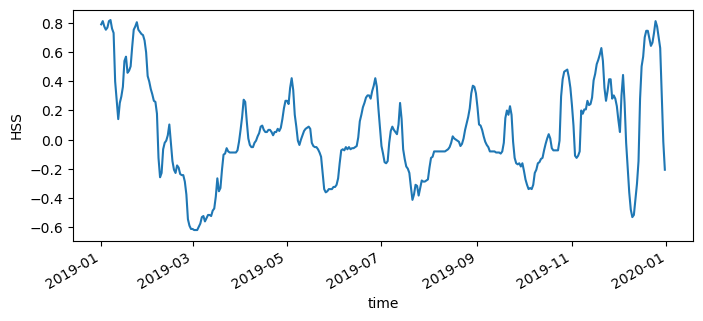

In [28]:
dsHSS= xr.Dataset({"HSS":(['time'],skill)
                       },
                       coords={'time':date_range})
dsHSS.HSS.plot(figsize=(8,3))
dsHSS.HSS.mean()

In [30]:
# skill = []
# for time in anom_obs_mask_us['time']:
#     print(time)
#     vCPCtmp = anom_obs_mask_us.sel(time=time)
#     # vCPCtmp = anom_obs_mask_us.sel(time=time,method='nearest')
#     vCPC    = np.array(vCPCtmp)[vCPCtmp.notnull()]
#     ANOMtmp = anom_mask_us.sel(time=time)
#     # ANOMtmp = anom_mask_us.sel(time=time,method='nearest')
#     ANOM    = np.array(ANOMtmp)[ANOMtmp.notnull()]
#     SPREADtmp = spread_mask_us.sel(time=time)
#     SPREAD    = np.array(SPREADtmp)[SPREADtmp.notnull()]
#     bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
#     OBS = get_categorical_obs((vCPC,),bounds)[0]
#     bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
#     PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]
#     HSS = get_heidke(PROB.T,OBS.T,categorical=True)
#     skill.append(HSS)
    # break

In [52]:
bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
K = len(bounds)-1
print(np.asarray(bounds).shape)
# bounds[0]
# bounds[0][0]
# OBS = get_categorical_obs((vCPC,),bounds)[0]

(3, 270)


In [70]:
K = len(bounds)-1
cat_obs = []

for i,x in enumerate(vCPC):
    interval_membership = []
    for c in range(K):
        is_within_interval = (x > bounds[c][i]) and (x < bounds[c + 1][i])
        # print('----------')
        # print(i,c)
        # print(bounds[c][i],bounds[c + 1][i])
        interval_membership.append(is_within_interval)
        # print('----------')
    # print(interval_membership)
    cat_obs.append(interval_membership)
cat_fcst = []
# print('---cat_fcst---')
for i,x in enumerate(ANOM):
    interval_membership = []
    for c in range(K):
        is_within_interval = (x > bounds[c][i]) and (x < bounds[c + 1][i])
        interval_membership.append(is_within_interval)
    # print(interval_membership)
    cat_fcst.append(interval_membership)
# cat_fcst
    
# print(x)
# print(np.asarray(bounds).shape)
# print(bounds[0].shape,bounds[0+1].shape)

# np.array([(x>bounds[c]) & (x<bounds[c+1]) for c in range(K)])
# cat_obs
cat_fcst = np.array(cat_fcst)
cat_obs  = np.array(cat_obs)
cat_fcst.shape

(270, 2)

In [67]:
K = len(bounds)-1
cat_obs_Sam = np.array([np.array([(x>bounds[c]) & (x<bounds[c+1]) for c in range(K)]) for x in vCPC][0]).T
print(cat_obs_Sam.shape)
# cat_obs_Sam


(270, 2)


In [64]:
result = [a == b for a, b in zip(cat_obs[:,0], cat_obs_Sam[:,0])]

# Count the number of True results
count = result.count(True)
count

158

In [51]:
count

114

In [71]:
N,C = cat_fcst.shape
hits = np.sum(np.sum(cat_fcst*cat_obs,axis=1))# first sum gives 1 as hit and 0 as miss; second sum adds up 1s and 0s to get total hits
print(hits)
HSS = (hits-N/C)/(N-N/C)
print(N,C,hits, HSS)


114
270 2 114 -0.15555555555555556


In [73]:
bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
OBS = get_categorical_obs((vCPC,),bounds)[0]
bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]

In [74]:
cat_fcst=PROB.T
cat_obs=OBS.T
weights=None
categorical=False
N,C = cat_fcst.shape
if weights is None:
    weights = np.ones(N)
N = sum(weights)
if categorical:
    cat_fcst = np.round(cat_fcst)
print(cat_fcst.shape)
print(cat_obs.shape)
print(weights.shape)

if N==0:
    H1 = 0
else:
    H1 = N**-1 * np.sum(np.sum(cat_fcst*cat_obs,axis=1)*weights)
H2 = 1/C
#    H2 = N**-2 * np.sum(np.sum((cat_fcst*cat_obs+(1-cat_fcst)*cat_obs)*weights[:,None],axis=1)*
#                       np.sum((cat_fcst*cat_obs+cat_fcst*(1-cat_obs))*weights[:,None],axis=1))
HSS = (H1 - H2) / (1 - H2)
print(HSS)

(270, 2)
(270, 2)
(270,)
-0.017134422143669337


In [75]:
K = len(bounds)-1
print(K)
cat_obs = [np.array([(x>bounds[c]) & (x<bounds[c+1]) for c in range(K)]) for x in OBS]
np.asarray(cat_obs).shape

2


(2, 2, 270)

In [76]:
bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]

In [77]:
PROB.T.shape

(270, 2)

In [78]:
HSS = get_heidke(PROB.T,OBS.T,categorical=True)
print(HSS)

-0.15555555555555556


In [79]:
HSS

-0.15555555555555556

In [ ]:
print(vCPC[0:2])
print(cat_obs